# This notebook was created to find all of the High Quality SNV calls for all of the isolates in rollingDB, changed from previous version by NOT using Lineage Calls from MegaPipe

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }<|/style>"))

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools
import gzip

import networkx as nx
import scipy
import pickle

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

####################################################################################################################################################################################

## [1] This section of the notebook loads all of the Lineage Calls that were made on the isolates in rollingDB as well as the mean coverage / isolates for all of the isolates in rollingDB. 

####################################################################################################################################################################################

#### We run through the pilon-generated VCF for each isolate (N = 33,875) and scrapes the High Quality Single Nucleotide Variant calls made against H37Rv. The DataFrame containing these high quality SNV calls (with the Reference Position, Reference Allele and Alterante Allele) for each isolate is then stored in a directory containing all of the DFs for all isolates. 

#### Side-Note: Some isolate have ~20x coverage and we require 20 reads at a given position to make a SNP call

### Scrape Luca's DB

In [3]:
#genomic data directory
rolling_DB_dir = '/n/data1/hms/dbmi/farhat/rollingDB/genomic_data/'

#get all folders (each folder corresponds to a different sequenced isolate)
isolate_directories = os.listdir(rolling_DB_dir)

#iterate through each sequenced isolate
isolate_i = 0

for isolate_ID in isolate_directories:

    #directory that stores files for each sequenced isolate
    directory_for_sequenced_isolate = rolling_DB_dir + isolate_ID

    #check to see if megapipe successfully ran on sequenced isolate
    try:
        #existence of a PILON directory and corresponding VCF file
        if ( 'pilon' in os.listdir(directory_for_sequenced_isolate) ):
            
            #existence of a REDUCED VCF and existence of FULL VCF file in relevent directories 
            if ( 'vcf' in list( itertools.chain.from_iterable( [filename.split('.') for filename in os.listdir(directory_for_sequenced_isolate + '/pilon/')] ) ) ) and ( isolate_ID + '_full' in list( itertools.chain.from_iterable( [filename.split('.') for filename in os.listdir(directory_for_sequenced_isolate + '/pilon/')] ) ) ):
                
                #we have a valid VCF file so megapipe ran successfully, let's keep the variant call information for this sequenced isolate
                
                #PILON-generated VCF DATA
                ########################################################################################################################
                
                #dictionaries to construct DataFrame from later that hold information about each high-quality SNP found for a specific isolate from rollingDB
                ref_dict = {} #reference allele
                alt_dict = {} #alternate allele
                alt_AF_dict = {} #frequency of alternate allele in population (0.75 - 1.0)
                
                #load in VCF file if one was found
                vcf_reader = vcf.Reader( open(directory_for_sequenced_isolate + '/pilon/' + isolate_ID + '.vcf' , 'r') )

                #iterate through each Variant Call 
                for record in vcf_reader:
                    
                    #check to see if the call is a PASS by Pilon
                    if record.FILTER == []:

                        #check to see if variant is SNP (length of Reference Allele is 1 base ; there's only 1 alternate allele ; length of alternate allele is 1 base)
                        if (len(record.REF) == 1) and (len(record.ALT) == 1) and (len(str(record.ALT[0])) == 1):

                            ##### Retrieve Relevant information for filtering quality of Base Call #####
                            # Mean Base Quality @ locus
                            BQ = record.INFO['BQ']
                            # Mean Mapping Quality @ locus
                            MQ = record.INFO['MQ']
                            # Number of Reads w/ Deletion 
                            DC = record.INFO['DC']
                            # Number of Reads w/ Insertion
                            IC = record.INFO['IC']
                            # Depth of Valid Reads in Pileup
                            VD = record.INFO['DP']

                            ### Filtering Criteria
                            #---> Mean Base Quality > 20
                            #---> Mean Mapping Quality > 30
                            #---> No Reads Supporting Insertions
                            #---> No Reads Supporting Deletions
                            #---> Number of High Quality Reads >= 20
                            if (BQ > 20) and (MQ > 30) and (DC == 0) and (IC == 0) and (VD >= 20): #SNP passed filtering criteria!

                                # Filtering Criteria for mutant allele frequency calculation (range: 0.75 - 1.0)
                                ref_allele = str( record.REF )
                                alt_allele = str( record.ALT[0] )
                                ref_pos = int( record.POS )
                                
                                # Calculate Alternate Allele Frequency
                                # only stores SNV if 1 or 2 bases are supported by reads
                                ########################################################################
                                #position-base dictionaries (order of output in Pilon)
                                base_order = {0:'A' , 1:'C' , 2:'G', 3:'T'}
                                base_order_r = {'A':0 , 'C':1 , 'G':2 , 'T':3}

                                # Quality-Percentage - Percentage of As, Cs, Gs, Ts weighted by Q & MQ at locus
                                QP = record.INFO['QP']

                                if (sum(np.array(QP) == 0) == 3): #1 Allele supported by Reads (Alternate), store information for this Base Call (3 bases have NO reads supporting)

                                    #create a Boolean list for the Bases that have at least 1% of support from reads
                                    supported_bases_boolean = list( np.array( QP ) > 0 )

                                    #positions of Bases [A,C,G,T] with at least 1% of support from reads
                                    supported_bases_i = [i for i,x in enumerate(supported_bases_boolean) if x == True] #returns list of length 
                                    supported_base = base_order[supported_bases_i[0]]

                                    #if the Reference Allele is supported
                                    if supported_base == ref_allele:
                                        alt_allele_frequency = 0.0 #no alternate allele

                                    #if an Alternate Allele is supported:
                                    if supported_base != ref_allele:
                                        alt_allele_frequency = 1.0 #alternate allele

                                elif (sum(np.array(QP) == 0) == 2): #2 Alleles supported, make sure 1 is the Reference & confirm the Alternate (2 bases have NO reads supporting)

                                    #position of the Reference Allele in [A,C,G,T]
                                    ref_allele_base_i = base_order_r[ref_allele] 

                                    #create a Boolean list for the Bases that have at least 1% of support from reads
                                    supported_bases_boolean = list( np.array( QP ) > 0 )

                                    #positions of Bases [A,C,G,T] with at least 1% of support from reads
                                    supported_bases_i = [i for i,x in enumerate(supported_bases_boolean) if x == True] #returns list of length 2

                                    #check that Reference Allele is supported by at least 1% of the reads
                                    if ref_allele_base_i in supported_bases_i:

                                        #find the Alternate Allele that was supported by at least 1% of the reads
                                        for supported_base_i in supported_bases_i:

                                            if supported_base_i != ref_allele_base_i: #then must be alternate allele

                                                alt_allele = base_order[supported_base_i] #Alternate Allele
                                                alt_allele_frequency = float(QP[supported_base_i]) / 100.0 #weighted percentage of reads supporting Alternate Allele
                                                break
                                ########################################################################
                                
                                # use only consensus SNPs (where alternate allele frequency >= 75%)
                                if alt_allele_frequency >= 0.75:
                                
                                    # Store good-quality SNV in SNV dictionaries
                                    ref_dict[ref_pos] = ref_allele
                                    alt_dict[ref_pos] = alt_allele

                #construct DataFrame from dictionaries
                SNV_DF = pd.DataFrame( index = pd.Series( ref_dict.keys() ) )
                SNV_DF['ref'] = pd.Series(ref_dict)
                SNV_DF['alt'] = pd.Series(alt_dict)

                #make reference-position a column and re-index, sort according to reference position
                SNV_DF['pos'] = SNV_DF.index
                SNV_DF.sort_values(by = 'pos' , ascending = True , inplace = True)
                SNV_DF.reset_index(inplace = True , drop = True)

                #pickle DataFrame holding High Quality SNVs from isolate
                SNV_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB/' + isolate_ID + '_SNVs.pkl')
                ########################################################################################################################
                
                #keep track of progress   
                isolate_i += 1
                if isolate_i % np.ceil(0.05*len(isolate_directories)) == 0:
                    print float(isolate_i) / float(len(isolate_directories))
        
    except OSError: #hit some file that is not another directory with genomic data 
        continue

0.0500090232801
0.10001804656
0.15002706984
0.20003609312
0.2500451164
0.30005413968
0.35006316296
0.400072186241
0.450081209521
0.500090232801
0.550099256081
0.600108279361
0.650117302641


####################################################################################################################################################################################

## [2] This section of the notebook constructs a script that iterates over *subsets* of the HQ SNV DataFrames for each isolate and creates a 'catalogue' of all of the HQ SNVs found in rollingDB. All of the relevent information is stored in dictionaries before being transformed into a DataFrame with all of the unique SNVs (indexed by Reference Position) and the number of isolates that contain a SNV at that position.

####################################################################################################################################################################################

In [ ]:
import vcf
import os
import pandas as pd
import numpy as np
from pylab import MaxNLocator
import ast
import itertools
import time
import sys
import itertools
import gzip
import scipy

#### We are going to split this up into several jobs, each iterating through N isolates. Each job will produce a DF with all SNVs detected in any of the N isolates & corresponding alleles.  Once all jobs have finished, we will merge all DFs together to create one master DF of all SNVs detected in any of the 33,875 isolates in rollingDB

In [16]:
#INPUTS
first_isolate_index = int(sys.argv[1]) #INPUT - first isolate index
last_isolate_index = int(sys.argv[2]) #INPUT - last isolate index
job_number = str(sys.argv[3]) #INPUT - job number

In [14]:
#list of pickles DataFrame files for SNVs for each isolate in rollingDB
SNV_DF_list = os.listdir('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB')

#subset to only the pickled DFs for the isolates that will be searched for SNVs in this job
SNV_DF_list = SNV_DF_list[first_isolate_index:last_isolate_index]

In [49]:
def store_SNV_info_from_SNV(SNV_DF_row):

    ref_allele , alt_allele , ref_pos = list(SNV_DF_row)

    #SNV is not documented at this Reference Position
    if ref_pos not in ref_dict.keys():

        #store a new row for SNV at this reference position; ref allele, alt allele 1, nan, nan, 1 isolate has polymorphism here (so far)
        ref_dict[ref_pos] = ref_allele
        alt1_dict[ref_pos] = alt_allele
        alt2_dict[ref_pos] = np.nan
        alt3_dict[ref_pos] = np.nan
        num_isolates_dict[ref_pos] = 1

    #a SNV is already documented at this Reference Position
    else:

        #check to see if specific allele is documented, if not add it
        if alt_allele not in [alt1_dict[ref_pos] , alt2_dict[ref_pos] , alt3_dict[ref_pos]]:

            #need to document presence of new allele in isolate pool (either going to be alt2 or alt3)
            if ( type(alt2_dict[ref_pos])==float ) and ( np.isnan(alt2_dict[ref_pos]) ): #alt2 has not been found yet

                alt2_dict[ref_pos] = alt_allele

            elif ( type(alt3_dict[ref_pos])==float ) and ( np.isnan(alt3_dict[ref_pos]) ): #alt3 has not been found yet

                alt3_dict[ref_pos] = alt_allele

        #increment # of isolates that have a polymorphism here
        num_isolates_dict[ref_pos] = num_isolates_dict[ref_pos] + 1

In [ ]:
#create dictionaries to store SNV info for each isolate
ref_dict = {}
alt1_dict = {}
alt2_dict = {}
alt3_dict = {}
num_isolates_dict = {}

#iterate through all DataFrames for each isolate in rollingDB
for pickled_SNV_DF in SNV_DF_list:
    
    #load SNV DF for isolates from pickled object
    SNV_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB/' + pickled_SNV_DF)

    #extract important info from SNV df
    _ = SNV_DF.apply(lambda row: store_SNV_info_from_SNV(row) , axis = 1 )  

In [23]:
#construct DataFrame from dictionaries
SNV_DF = pd.DataFrame( index = pd.Series( ref_dict.keys() ) )
SNV_DF['ref'] = pd.Series(ref_dict)
SNV_DF['alt1'] = pd.Series(alt1_dict)
SNV_DF['alt2'] = pd.Series(alt2_dict)
SNV_DF['alt3'] = pd.Series(alt3_dict)
SNV_DF['num_isolates'] = pd.Series(num_isolates_dict)

#make reference-position a column and re-index
SNV_DF['pos'] = SNV_DF.index

#sort according to reference position
SNV_DF.sort_values(by = 'pos' , ascending = True , inplace = True)

SNV_DF.reset_index(inplace = True , drop = True)

#### Output Pickle files for downstream analysis

In [24]:
SNV_DF.to_pickle( '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB_catalogues/seperate_HQ_SNV_DFs/HighQuality_SNVs_found_in_rollingDB_catalogue_' + job_number + '.pkl' )

####################################################################################################################################################################################

## [3] This section of the notebook launches the script that was created in the previous section of the notebook.

####################################################################################################################################################################################

In [4]:
import os
import pandas as pd
from slurmpy import Slurm
import numpy as np
import itertools
import shutil

In [5]:
#list of all SNV DFs for each isolate that was run through MegaPipe in rollingDB
SNV_DF_list = os.listdir('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB')

isolates_per_job = 500 #number of isolates each job will catalogue
njobs = int( np.ceil( float( len( SNV_DF_list ) ) / float(isolates_per_job) ) ) #number of jobs required if we split for every 500 isolates

In [6]:
print njobs #number of jobs we will submit

68


In [7]:
first_isolate_index = 0
max_isolate_index = int( len( SNV_DF_list ) )

#run each job using a difference set of indices for isolates that we will catalogue SNVs from
for job_number in np.arange(1 , njobs+1):

    last_isolate_index = first_isolate_index + isolates_per_job
    if last_isolate_index > max_isolate_index: #watch out for the last job
        last_isolate_index = max_isolate_index
    
    rollingDB_SNV_cataloging_job = 'python /home/rv76/Farhat_Lab/Python_Scripts/homoplasy_project/rollingDB_HQ_SNV_catalogue_scrape.py ' + str(first_isolate_index) + ' ' + str(last_isolate_index) + ' ' + str(job_number)
    
    #directory where you want output + error files
    os.chdir('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB_catalogues/SNV_catalogue_scrape_jobs/')

    job_name = 'SNV_' + str(job_number)

    s = Slurm(job_name , {'partition':'short' , 'N':'1' , 't':'0-01:00:00' , 'mem':'4G' , 'mail-type':'FAIL' , 'mail-user':'roger_vargas@g.harvard.edu'})

    #submits the job
    job_id = s.run(rollingDB_SNV_cataloging_job)

    print job_name  + ' : ' +  str(job_id)
    
    #setup isolate indices for next job
    first_isolate_index = last_isolate_index

submitted: Submitted batch job 6825966


SNV_1 : 6825966


submitted: Submitted batch job 6825967


SNV_2 : 6825967


submitted: Submitted batch job 6825968
submitted: Submitted batch job 6825969


SNV_3 : 6825968
SNV_4 : 6825969


submitted: Submitted batch job 6825970
submitted: Submitted batch job 6825971


SNV_5 : 6825970
SNV_6 : 6825971


submitted: Submitted batch job 6825972
submitted: Submitted batch job 6825973
submitted: Submitted batch job 6825974


SNV_7 : 6825972
SNV_8 : 6825973
SNV_9 : 6825974


submitted: Submitted batch job 6825975
submitted: Submitted batch job 6825976
submitted: Submitted batch job 6825977
submitted: Submitted batch job 6825978


SNV_10 : 6825975
SNV_11 : 6825976
SNV_12 : 6825977
SNV_13 : 6825978


submitted: Submitted batch job 6825979
submitted: Submitted batch job 6825980


SNV_14 : 6825979
SNV_15 : 6825980


submitted: Submitted batch job 6825981
submitted: Submitted batch job 6825982
submitted: Submitted batch job 6825983
submitted: Submitted batch job 6825984


SNV_16 : 6825981
SNV_17 : 6825982
SNV_18 : 6825983
SNV_19 : 6825984


submitted: Submitted batch job 6825985


SNV_20 : 6825985


submitted: Submitted batch job 6825986
submitted: Submitted batch job 6825987


SNV_21 : 6825986
SNV_22 : 6825987


submitted: Submitted batch job 6825988
submitted: Submitted batch job 6825989


SNV_23 : 6825988
SNV_24 : 6825989


submitted: Submitted batch job 6825990
submitted: Submitted batch job 6825991


SNV_25 : 6825990
SNV_26 : 6825991


submitted: Submitted batch job 6825992
submitted: Submitted batch job 6825993


SNV_27 : 6825992
SNV_28 : 6825993


submitted: Submitted batch job 6825994
submitted: Submitted batch job 6825995
submitted: Submitted batch job 6825996


SNV_29 : 6825994
SNV_30 : 6825995
SNV_31 : 6825996


submitted: Submitted batch job 6825997
submitted: Submitted batch job 6825998
submitted: Submitted batch job 6825999


SNV_32 : 6825997
SNV_33 : 6825998
SNV_34 : 6825999


submitted: Submitted batch job 6826000
submitted: Submitted batch job 6826001
submitted: Submitted batch job 6826002


SNV_35 : 6826000
SNV_36 : 6826001
SNV_37 : 6826002


submitted: Submitted batch job 6826003
submitted: Submitted batch job 6826004


SNV_38 : 6826003
SNV_39 : 6826004


submitted: Submitted batch job 6826005


SNV_40 : 6826005


submitted: Submitted batch job 6826006
submitted: Submitted batch job 6826007
submitted: Submitted batch job 6826008
submitted: Submitted batch job 6826009


SNV_41 : 6826006
SNV_42 : 6826007
SNV_43 : 6826008
SNV_44 : 6826009


submitted: Submitted batch job 6826010
submitted: Submitted batch job 6826011
submitted: Submitted batch job 6826012


SNV_45 : 6826010
SNV_46 : 6826011
SNV_47 : 6826012


submitted: Submitted batch job 6826013
submitted: Submitted batch job 6826014


SNV_48 : 6826013
SNV_49 : 6826014


submitted: Submitted batch job 6826015
submitted: Submitted batch job 6826016
submitted: Submitted batch job 6826017
submitted: Submitted batch job 6826018


SNV_50 : 6826015
SNV_51 : 6826016
SNV_52 : 6826017
SNV_53 : 6826018


submitted: Submitted batch job 6826019


SNV_54 : 6826019


submitted: Submitted batch job 6826020
submitted: Submitted batch job 6826021
submitted: Submitted batch job 6826022
submitted: Submitted batch job 6826023


SNV_55 : 6826020
SNV_56 : 6826021
SNV_57 : 6826022
SNV_58 : 6826023


submitted: Submitted batch job 6826024
submitted: Submitted batch job 6826025
submitted: Submitted batch job 6826026
submitted: Submitted batch job 6826027


SNV_59 : 6826024
SNV_60 : 6826025
SNV_61 : 6826026
SNV_62 : 6826027


submitted: Submitted batch job 6826028
submitted: Submitted batch job 6826029
submitted: Submitted batch job 6826030
submitted: Submitted batch job 6826031


SNV_63 : 6826028
SNV_64 : 6826029
SNV_65 : 6826030
SNV_66 : 6826031
SNV_67 : 6826032
SNV_68 : 6826033


submitted: Submitted batch job 6826032
submitted: Submitted batch job 6826033


####################################################################################################################################################################################

## [4] The purpose of this section of the notebook is generate the master catalogue of (high-quality) SNV calls made in rollingDB by merging the catalogues of SNVs found in seperate batches of isolates.

####################################################################################################################################################################################

In [8]:
import os
import pandas as pd
import numpy as np
import ast
import itertools
import time
import sys
import itertools

In [9]:
#INPUTS
njobs = 68 #number of seperate SNV catalogues for subsets of isolates in rollingDB

#### Load in SNV catalogue(s) (High Quality SNV calls across all isolates in RollingDB)

We're going to iterate through each DataFrame (catalogue of SNVs detected within each batch of isolates) and create a master DF of all SNVs detected within all the isolates in rollingDB.

In [10]:
def convert_SNV_DF_rows_to_DICT_elments(row):
    
    '''
    This function converts the row of a SNV catalogue DF to a
    list with two elements: (1) The Reference Position of an SNV detected within a subset of isolates
    and (2) another list containing the Reference Allele, all Alternate Alleles, and Number of Isolates
    with an SNV at this Reference Position
    '''
    
    #create set of alternate alleles present for this SNV
    alt_alleles_SNV_i = set( [row['alt1'] , row['alt2'] , row['alt3']] )
    #purge nan values
    alt_alleles_SNV_i = {x for x in alt_alleles_SNV_i if x==x}
        
    return [ row['pos'] , [row['ref'] , alt_alleles_SNV_i , row['num_isolates']] ]

def convert_SNV_DF_to_DICT(SNV_DF):
    
    '''
    This function takes an SNV DF catalogue for a subset of isolates and converts it into 
    an SNV DICT catalogue using the function above by applying it to each row.
    '''
    
    SNV_dict = SNV_DF.apply( convert_SNV_DF_rows_to_DICT_elments , axis = 1 )
    return dict(list( SNV_dict.values ))

#### Convert SNV catalogue(s) DFs to SNV catalogue DICTs and store SNP catalogue info across jobs

In [11]:
#master set of all reference positions detected within rollingDB (faster to query a set)
SNV_set_Ref_Position = set([])

#master dictionaries of all SNVs detected within rollingDB
SNV_dict_Ref_Allele = {} #keys - reference position; values - ref_allele (string)
SNV_dict_Alt_Allele = {} #keys - reference position; values - alt_alleles (set)
SNV_dict_Num_Isolates = {} #keys - reference position; values - num_isolates (int)

for job_num in np.arange(1 , njobs+1):
    
    #load the SNV DataFrame holding SNVs from the batch of isolates
    SNV_DF_subset = pd.read_pickle( '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB_catalogues/seperate_HQ_SNV_DFs/HighQuality_SNVs_found_in_rollingDB_catalogue_' + str(job_num) + '.pkl' )
    
    #convert SNV DataFrame to an SNV Dict
    SNV_dict_subset = convert_SNV_DF_to_DICT(SNV_DF_subset)
    
    #iterate through each SNV in Dict
    for ref_pos in SNV_dict_subset.keys():
        
        #update master SNV catalogue dict with SNV info
        ref , alt_alleles_SNV_i , num_isolates = SNV_dict_subset[ref_pos]
    
        #[A] reference position not stored in master SNV dictionaries
        ##if ref_pos not in SNV_dict_Ref_Allele.keys():
        if ref_pos not in SNV_set_Ref_Position:
            
            SNV_set_Ref_Position.add(ref_pos)
            
            SNV_dict_Ref_Allele[ref_pos] = ref
            SNV_dict_Alt_Allele[ref_pos] = alt_alleles_SNV_i
            SNV_dict_Num_Isolates[ref_pos] = num_isolates
        
        #[B] reference position already stored in master SNV dictionaries
        else:
            
            #update SNV info with new SNV info (ref_allele stays the same)
            SNV_dict_Alt_Allele[ref_pos] = SNV_dict_Alt_Allele[ref_pos].union(alt_alleles_SNV_i) #store any new alleles detected
            SNV_dict_Num_Isolates[ref_pos] = SNV_dict_Num_Isolates[ref_pos] + num_isolates #add number of isolates
            
    #keep track of progress
    print job_num

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


#### Convert master SNV dict to SNV df 

In [12]:
#convert dictionaries into pandas series objects
SNV_series_Ref_Allele = pd.Series(SNV_dict_Ref_Allele , name = 'ref')
SNV_series_Alt_Allele = pd.Series(SNV_dict_Alt_Allele , name = 'alt')
SNV_series_Num_Isolates = pd.Series(SNV_dict_Num_Isolates , name = 'num_isolates')

#construct DataFrame from Series objects
SNV_DF = pd.DataFrame([SNV_series_Ref_Allele , SNV_series_Alt_Allele , SNV_series_Num_Isolates]).T

#convert Alternate Allele(s) column to list
SNV_DF['alt'] = SNV_DF.alt.apply(list)

#create a column for reference position
SNV_DF['pos'] = list(SNV_DF.index)

#re-index DataFrame
SNV_DF.reset_index(inplace = True , drop = True)

#store master SNV DataFrame as a pickled object
SNV_DF.to_pickle( '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB_catalogues/all_HighQuality_SNVs_found_in_rollingDB_catalogue.pkl' )

#### Use to load pickle

In [13]:
SNV_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB_catalogues/all_HighQuality_SNVs_found_in_rollingDB_catalogue.pkl')

In [14]:
SNV_DF.head()

,ref,alt,num_isolates,pos
0,A,[C],3,8
1,G,[C],1,10
2,A,[C],11,11
3,C,[T],1,15
4,G,[C],1,16


In [15]:
SNV_DF.tail()

,ref,alt,num_isolates,pos
899030,A,[C],1,4411513
899031,G,[A],1,4411514
899032,A,[G],1,4411516
899033,C,[T],4,4411518
899034,G,[A],3,4411522


In [16]:
np.shape(SNV_DF)

(899035, 4)

####################################################################################################################################################################################

## [5] The purpose of this section of the notebook is to analyze the catalogue of (high-quality) SNV calls made in rollingDB. For population genetic analyses, we will retain only SNVs that are present in at least 1 isolate. We then construct a skeleton genotype DF (rows = Reference Position , columns = isolates) for all of the remaining SNVs.

####################################################################################################################################################################################

### Construct a series for the isolate annotation

In [17]:
HQ_SNV_per_isolate_files = os.listdir('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB/')
isolate_ids_list = [isolate_id.split('_SNV')[0] for isolate_id in HQ_SNV_per_isolate_files]
isolate_id_series = pd.Series(isolate_ids_list)

In [18]:
isolate_id_series.head() #index = column indices of genotype matrix, values isolate IDs

0    SAMEA3558733
1    SAMN05575260
2    SAMN03648641
3    SAMN03647419
4    SAMEA3671418
dtype: object

In [19]:
np.shape(isolate_id_series)

(33875,)

#### Remove 2 bad isolates from isolate annotation

**Remove:** Delete ID for isolate **IDR1400002533** since Full GZipped VCF looks corrupt and remove from list accordingly!

In [20]:
isolate_id_series = isolate_id_series[isolate_id_series != 'IDR1400002533']

**Remove:** Delete ID for **Peru4994** since F2 calculations keeps failing for this isolate (lineage-defining SNP depths df is empty) **Think this is because sample has very low coverage**

In [21]:
isolate_id_series = isolate_id_series[isolate_id_series != 'Peru4994']

In [22]:
isolate_id_series.reset_index(inplace = True, drop = True)

In [23]:
isolate_id_series.head()

0    SAMEA3558733
1    SAMN05575260
2    SAMN03648641
3    SAMN03647419
4    SAMEA3671418
dtype: object

In [24]:
len(isolate_id_series)

33873

In [25]:
isolate_id_series.to_pickle( '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/genotypes_isolate_annotation.pkl' )

### Load in catologue of SNVs detected within rollingDB

In [26]:
#SNV data for all isoaltes in rollingDB 
SNV_DF = pd.read_pickle( '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB_catalogues/all_HighQuality_SNVs_found_in_rollingDB_catalogue.pkl' )

In [27]:
SNV_DF.head()

,ref,alt,num_isolates,pos
0,A,[C],3,8
1,G,[C],1,10
2,A,[C],11,11
3,C,[T],1,15
4,G,[C],1,16


In [28]:
np.shape(SNV_DF)

(899035, 4)

#### How many SNPs are not biallelic?

In [29]:
#SNPs that are not biallelic will have more than 1 alternate allele
np.sum( SNV_DF.alt.apply(len) > 1 )

64950

In [30]:
SNV_DF[SNV_DF.alt.apply(len) > 1].head(n = 10)

,ref,alt,num_isolates,pos
8,A,"[C, G]",12,31
13,G,"[A, T]",3,67
28,C,"[A, T]",17,108
30,C,"[A, T]",2,116
36,T,"[C, G]",4,147
45,G,"[A, C]",2,186
48,G,"[C, T]",3,195
51,G,"[A, C]",4,203
55,G,"[A, C]",2,234
56,G,"[A, T]",2,236


In [31]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

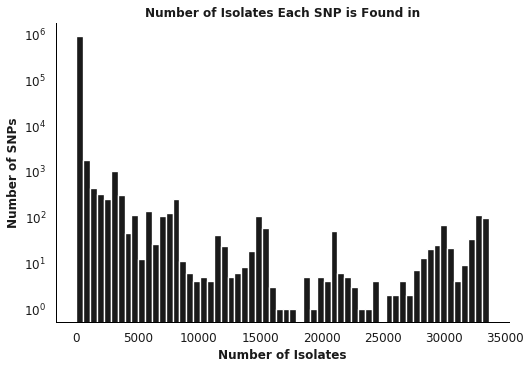

In [32]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist(SNV_DF.num_isolates.astype(float) , bins = 60 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=1.35)

plt.title('Number of Isolates Each SNP is Found in', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.xlabel('Number of Isolates', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.ylabel('Number of SNPs', fontweight = 'bold' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')
ax.set_yscale("log", nonposy='clip')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#file_name = '/home/rv76/Farhat_Lab/Figures/Final_5/Scraping_rollingDB/Mean_Coverage_Distribution_across_all_isolates.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### How many SNP sites have at least *1* isolate with an alternate allele?

In [33]:
np.shape(SNV_DF[SNV_DF.num_isolates >= 1])

(899035, 4)

#### How many SNP sites have at least *2* isolates with an alternate allele?

In [34]:
np.shape(SNV_DF[SNV_DF.num_isolates >= 2])

(429880, 4)

#### How many SNP sites have at least *3* isolates with an alternate allele?

In [35]:
np.shape(SNV_DF[SNV_DF.num_isolates >= 3])

(262010, 4)

#### How many SNP sites have at least *4* isolates with an alternate allele?

In [36]:
np.shape(SNV_DF[SNV_DF.num_isolates >= 4])

(193209, 4)

#### How many SNP sites have at least *5* isolates with an alternate allele?

In [37]:
np.shape(SNV_DF[SNV_DF.num_isolates >= 5])

(153603, 4)

### Keep only SNVs in which the corresponding *Reference Position* has a SNV in $\ge$ 1 isolate

SNVs found in only 0 isolates are dropped

In [38]:
SNV_DF = SNV_DF[SNV_DF.num_isolates >= 1]

In [39]:
np.shape(SNV_DF)

(899035, 4)

In [40]:
SNV_DF.head()

,ref,alt,num_isolates,pos
0,A,[C],3,8
1,G,[C],1,10
2,A,[C],11,11
3,C,[T],1,15
4,G,[C],1,16


#### Re-Structure DataFrame to include only the Reference Position, Reference Allele and Alternate Allele(s)

In [41]:
SNV_annotation_DF = pd.DataFrame(index = range( 0 , np.shape(SNV_DF)[0] ) ) #index for each SNV
SNV_annotation_DF['pos'] = list(SNV_DF.pos) #H37Rv Reference Position
SNV_annotation_DF['ref'] = list(SNV_DF.ref) #reference allele
SNV_annotation_DF['alt'] = list(SNV_DF.alt) #alterante allele(s) list

In [42]:
np.shape(SNV_annotation_DF)

(899035, 3)

In [43]:
SNV_annotation_DF.head() #index = row indices of genotype matrix , 0 supports ref, 1 supports alt

,pos,ref,alt
0,8,A,[C]
1,10,G,[C]
2,11,A,[C]
3,15,C,[T]
4,16,G,[C]


#### This is the DataFrame which we'll use to extract SNVs of interest when iterating over all of the VCF files in rollingDB

Output Annotation for SNVs of interest in Genotypes folder

In [44]:
SNV_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/genotypes_SNP_annotation.pkl')

#### Create a text file with a single column of all Reference Positions that we're interested in based off of DF above. We will use this text file to subset the *full* VCF files to only the positions that Reference Positions that have a SNV in at least 1 isolate.

In [45]:
SNV_ref_positions = ['NC_000962.3\t' + ref_pos for ref_pos in list( SNV_annotation_DF.pos.astype(str) ) ]

#save each element as a new row in a text file
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/ref_positions_to_select.txt', 'w') as f:
    for item in SNV_ref_positions:
        f.write("%s\n" % item)

####################################################################################################################################################################################

## [6] This section of the notebook prepares the script that iterates over all of the VCF files in rollingDB and outputs a genotype vector.

####################################################################################################################################################################################

In [20]:
import vcf
import os
import pandas as pd
import numpy as np
import sys

In [21]:
isolate_ID = 'Peru4988' #INPUT - isolate ID

#### Load SNV-Index annotation (for indexing genotypes)

In [5]:
SNV_annotation_DF = pd.read_pickle( '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/genotypes_SNP_annotation.pkl' )

In [6]:
SNV_annotation_DF.head()

,pos,ref,alt
0,8,A,[C]
1,10,G,[C]
2,11,A,[C]
3,15,C,[T]
4,16,G,[C]


#### Convert SNV annotation into dictionaries with keys = ROW indices of genotype array

In [7]:
#keys: H37Rv Reference Position , values: Genotype Row Index
ref_pos_dict = dict( zip( list(SNV_annotation_DF.pos) , list(SNV_annotation_DF.index) ) )

#### Create set of H37Rv Reference Positions that are SNP sites

In [14]:
H37Rv_ref_positions_of_interest = set(SNV_annotation_DF.pos)

#### Construct 'skeleton' Numpy Array that will store the supported base for all Reference Positions of interest for a single isolate in rollingDB

- **0** for _A_
- **1** for _C_
- **2** for _G_
- **3** for _T_
- **9** for Bad Quality SNV calls

In [15]:
#number of Reference Positions we're interested in (where High Quality SNV calls were made)
number_of_SNVs = len(ref_pos_dict.keys())

In [16]:
number_of_SNVs

899035

#### In constructing the Genotype Vector, we're going to iterate through all Reference Positions of interest and find the supported base from the VCF file for each position

In [17]:
#create an empty numpy array to store genotypes
genotypes_array = np.full(number_of_SNVs , 9 , dtype = int)

In [18]:
genotypes_array

array([9, 9, 9, ..., 9, 9, 9])

In [19]:
np.shape(genotypes_array)

(899035,)

### Iterate through the subset VCF file corresponding to the isolate in rollingDB and fill in genotypes vector

In [28]:
#genomic data directory
VCF_genotypes_dir = '/n/data1/hms/dbmi/farhat/rollingDB/genomic_data/'

#directory that stores files for each sequenced isolate
directory_for_sequenced_isolate = VCF_genotypes_dir + isolate_ID + '/pilon/'

#position-base dictionaries (order of output in Pilon)
base_order = {0:'A' , 1:'C' , 2:'G', 3:'T'}
base_order_r = {'A':0 , 'C':1 , 'G':2 , 'T':3}

#load in VCF file if one was found
vcf_reader = vcf.Reader( open(directory_for_sequenced_isolate  + isolate_ID + '_full.vcf.gz' , 'r') )

#iterate through each Variant Call 
for record in vcf_reader:
    
    #check to see if H37Rv Reference Position is one of the SNP sites of interest
    if record.POS in H37Rv_ref_positions_of_interest:
    
        #check to see if variant is SNP (length of Reference Allele is 1 base and there's only 1 alternate allele and length of alternate allele is 1 base is alternate allele exists)
        if (len(record.REF) == 1) and (len(record.ALT) == 1) and ( (record.ALT[0] == None) or (len(str(record.ALT[0])) == 1) ):

            #check to see if the call is a PASS by Pilon
            if record.FILTER == []:

                ##### Retrieve Relevant information for filtering quality of Base Call #####
                # Mean Base Quality @ locus
                BQ = record.INFO['BQ']
                # Mean Mapping Quality @ locus
                MQ = record.INFO['MQ']
                # Number of Reads w/ Deletion 
                DC = record.INFO['DC']
                # Number of Reads w/ Insertion
                IC = record.INFO['IC']
                # Depth of Valid Reads in Pileup
                VD = record.INFO['DP']

                ### Filtering Criteria
                #---> Mean Base Quality > 20
                #---> Mean Mapping Quality > 30
                #---> No Reads Supporting Insertions
                #---> No Reads Supporting Deletions
                #---> Number of High Quality Reads >= 20
                if (BQ > 20) and (MQ > 30) and (DC == 0) and (IC == 0) and (VD >= 20): 

                    # Quality-Percentage - Percentage of As, Cs, Gs, Ts weighted by Q & MQ at locus
                    QP = record.INFO['QP']

                    if (sum(np.array(QP) >= 75) == 1): #1 Allele is supported by at least 75% of the reads, store information for this Base Call

                        #create a Boolean list for the Bases that have at least 75% of support from reads
                        supported_bases_boolean = list( np.array( QP ) >= 75 )

                        #position of Base [A,C,G,T] with at least 75% of support from reads
                        supported_bases_i = [i for i,x in enumerate(supported_bases_boolean) if x == True] #returns list of length 
                        supported_base = base_order[supported_bases_i[0]]

                        #write an exception in case a SNV (with a reference position that we're not interested in) 'sneaks' past the subsetting and filtering
                        try:
                            #store a '0', '1', '2', or '3' in Genotype Vector (Reference Position Index) referencing the Base with at least 90% support from the reads
                            genotypes_array[ref_pos_dict[record.POS]] = base_order_r[supported_base]
                        except KeyError:
                            pass

Pickle Genotypes Array for downstream analysis

In [30]:
genotypes_array

array([0, 2, 0, ..., 0, 1, 2])

In [20]:
np.save('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/Genotypes_per_isolate/' + isolate_ID + '/' + isolate_ID + '_genotypes' , genotypes_array , allow_pickle = True)

####################################################################################################################################################################################

## [7] This section of the notebook launches the script that was created in the previous section of the notebook and submits jobs for batches of isolates to make genotypes arrays for each isolate.

####################################################################################################################################################################################

In [3]:
import os
import pandas as pd
from slurmpy import Slurm
import numpy as np
import itertools
import shutil

Every isolate in the pool of **33,873** isolates in rollingDB had a reduced VCF file and a corresponding Full VCF file. We will iterate through each of these Full VCF files and extract the base calls for only the **899,035** reference positions that we're interested in.

In [4]:
isolate_id_series = pd.read_pickle( '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/genotypes_isolate_annotation.pkl' )

In [5]:
isolate_id_series.head()

0    SAMEA3558733
1    SAMN05575260
2    SAMN03648641
3    SAMN03647419
4    SAMEA3671418
dtype: object

In [6]:
len(isolate_id_series)

33873

#### Create directory for each isolate to store output for genotyping (only run this once)

In [8]:
'''
for tag in isolate_id_series.values:

    #create directory to store subset VCF and genotypes for each isolate
    isolate_genotype_dir = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/Genotypes_per_isolate/' + tag
    if os.path.exists(isolate_genotype_dir):
        shutil.rmtree(isolate_genotype_dir)
        os.makedirs(isolate_genotype_dir)
    elif not os.path.exists(isolate_genotype_dir):
        os.makedirs(isolate_genotype_dir)
'''

__Check Progress of Jobs:__ Isolates that need to have Full VCF >> Genotypes Array Reference Positions of Interest

In [7]:
isolate_ids_to_run_VCF_extraction = []
isolate_ids_completed = []

for tag in isolate_id_series.values:

    #create directory to store subset VCF and genotypes for each isolate
    isolate_genotype_dir = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/Genotypes_per_isolate/' + tag
    
    #genotypes array file
    genotypes_array_path = isolate_genotype_dir + '/' + tag + '_genotypes.npy'
    
    #check for the existence of a genotypes file, if TRUE job has either started or completed
    if os.path.exists(genotypes_array_path):
            
        isolate_ids_completed.append(tag)
            
    #genotypes file doesn't exist, task never started
    else:
        
        isolate_ids_to_run_VCF_extraction.append(tag)

In [8]:
len(isolate_ids_completed)

32567

In [9]:
len(isolate_ids_to_run_VCF_extraction)

1306

#### Construct genotypes array for reference positions of interest for isolates that had Full VCF files 

In [10]:
isolate_id_series = pd.Series(isolate_ids_to_run_VCF_extraction)

#### Extract genotypes for each isolate from VCF file containing a subset of Reference Positions from the Full VCF files

Create BASH scripts to extract genotypes of N isolates per job

In [13]:
N_isolates_per_job = 115

njobs = int( np.ceil( float( len( isolate_id_series ) ) / float(N_isolates_per_job) ) ) #number of jobs required if we split for every N isolates

In [14]:
print njobs

44


In [15]:
bash_scripts = []

#split jobs up into tasks of N
for first_isolate_i_for_job in np.arange(0 , (njobs)*N_isolates_per_job , N_isolates_per_job):

    last_isolate_i_for_job = first_isolate_i_for_job + N_isolates_per_job
    
    commands_list = []

    for isolate_i in range(first_isolate_i_for_job , last_isolate_i_for_job): 

        try:
            tag = isolate_id_series[isolate_i]

            commands_list.append( 'python /home/rv76/Farhat_Lab/Python_Scripts/homoplasy_project/rollingDB_extract_HQ_SNV_genotypes.py {}'.format(tag) )
            
        except KeyError: #applies only to the last job if it has < N isolates
            continue
        
    bash_scripts.append(commands_list)

#### Submit each job to O2

In [16]:
job_num = 1
for job_i_commands_list in bash_scripts:
    
    #append all commands in a single string to be submitted as a job
    genotypes_extract_job = ''
    for command_i in job_i_commands_list:
        genotypes_extract_job  = genotypes_extract_job  + '\n' + command_i
    
    #directory where you want output + error files
    os.chdir('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/O2_SLURM_logs/make_genotypes_arrays_from_VCF/')

    job_name = 'Geno' + str(job_num)

    s = Slurm(job_name , {'partition':'short' , 'N':'1' , 't':'0-12:00:00' , 'mem':'2G' , 'mail-type':'FAIL' , 'mail-user':'roger_vargas@g.harvard.edu'})

    #submits the job
    job_id = s.run(genotypes_extract_job)

    print job_name  + ' : ' +  str(job_id)
    job_num += 1

submitted: Submitted batch job 6893609
submitted: Submitted batch job 6893611
submitted: Submitted batch job 6893613
submitted: Submitted batch job 6893615
submitted: Submitted batch job 6893617


Geno1 : 6893609
Geno2 : 6893611
Geno3 : 6893613
Geno4 : 6893615
Geno5 : 6893617


submitted: Submitted batch job 6893619
submitted: Submitted batch job 6893621
submitted: Submitted batch job 6893623


Geno6 : 6893619
Geno7 : 6893621
Geno8 : 6893623


submitted: Submitted batch job 6893624
submitted: Submitted batch job 6893625
submitted: Submitted batch job 6893626
submitted: Submitted batch job 6893627


Geno9 : 6893624
Geno10 : 6893625
Geno11 : 6893626
Geno12 : 6893627


submitted: Submitted batch job 6893628
submitted: Submitted batch job 6893629
submitted: Submitted batch job 6893630
submitted: Submitted batch job 6893631
submitted: Submitted batch job 6893632


Geno13 : 6893628
Geno14 : 6893629
Geno15 : 6893630
Geno16 : 6893631
Geno17 : 6893632


submitted: Submitted batch job 6893633
submitted: Submitted batch job 6893634
submitted: Submitted batch job 6893635
submitted: Submitted batch job 6893636
submitted: Submitted batch job 6893637


Geno18 : 6893633
Geno19 : 6893634
Geno20 : 6893635
Geno21 : 6893636
Geno22 : 6893637


submitted: Submitted batch job 6893638
submitted: Submitted batch job 6893639
submitted: Submitted batch job 6893640
submitted: Submitted batch job 6893641
submitted: Submitted batch job 6893642


Geno23 : 6893638
Geno24 : 6893639
Geno25 : 6893640
Geno26 : 6893641
Geno27 : 6893642


submitted: Submitted batch job 6893643
submitted: Submitted batch job 6893644
submitted: Submitted batch job 6893645
submitted: Submitted batch job 6893646


Geno28 : 6893643
Geno29 : 6893644
Geno30 : 6893645
Geno31 : 6893646


submitted: Submitted batch job 6893647
submitted: Submitted batch job 6893648
submitted: Submitted batch job 6893649
submitted: Submitted batch job 6893651


Geno32 : 6893647
Geno33 : 6893648
Geno34 : 6893649
Geno35 : 6893651


submitted: Submitted batch job 6893653
submitted: Submitted batch job 6893654
submitted: Submitted batch job 6893656
submitted: Submitted batch job 6893657
submitted: Submitted batch job 6893658


Geno36 : 6893653
Geno37 : 6893654
Geno38 : 6893656
Geno39 : 6893657
Geno40 : 6893658
Geno41 : 6893660
Geno42 : 6893661
Geno43 : 6893663
Geno44 : 6893665


submitted: Submitted batch job 6893660
submitted: Submitted batch job 6893661
submitted: Submitted batch job 6893663
submitted: Submitted batch job 6893665


####################################################################################################################################################################################

## [8] Inspect the distribution of missing values after Genotype Matrix is constructed (from genotype vectors) and filter out SNPs & Isolates

####################################################################################################################################################################################

In [3]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import pickle

### Make sure all isolates have a corresponding _genotypes_ array

In [4]:
isolate_id_series = pd.read_pickle( '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/genotypes_isolate_annotation.pkl' )

In [5]:
np.shape(isolate_id_series)

(33873,)

__Check for Genotypes Arrays:__ Get isolate IDs that have a corresponding genotypes array

In [6]:
isolate_ids_with_genotypes = []
isolate_ids_without_genotypes = []

for tag in isolate_id_series.values:

    #create directory to store subset VCF and genotypes for each isolate
    isolate_genotype_dir = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/Genotypes_per_isolate/' + tag
    
    #genotypes_array
    genotypes_array_pickle_file = isolate_genotype_dir + '/' + tag + '_genotypes.npy'
    
    #check for the existence of a genotypes file for this isolate
    if os.path.exists(genotypes_array_pickle_file):
            
        isolate_ids_with_genotypes.append(tag)
            
    else:
        
        isolate_ids_without_genotypes.append(tag)

In [7]:
len(isolate_ids_with_genotypes)

33873

In [8]:
len(isolate_ids_without_genotypes)

0

In [9]:
del isolate_ids_with_genotypes #clear variable from memory

### Concatenate genotypes arrays into a genotypes matrix for all isolates in rollingDB

Store the __genotypes array__ for each isolate into a list

In [10]:
genotypes_directory = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/Genotypes_per_isolate/'
genotype_arrays_per_isolate_list = []

#iterate through the genotypes arrays for each isolate
isolate_i = 0
for isolate_ID in isolate_id_series:
    
    #load genotypes array
    genotypes_array = np.load(genotypes_directory + isolate_ID + '/' + isolate_ID + '_genotypes.npy')
    
    #convert genotypes array from dtype 'int64' to 'int8' to save lots of memory
    genotypes_array = genotypes_array.astype('int8')
    
    #store genotypes array for this isolate in a list with all other genotypes arrays
    genotype_arrays_per_isolate_list.append(genotypes_array)
    
    if isolate_i % 1000 == 0:
        print float(isolate_i) / float(len(isolate_id_series))
    isolate_i += 1

0.0
0.0295220382015
0.059044076403
0.0885661146046
0.118088152806
0.147610191008
0.177132229209
0.206654267411
0.236176305612
0.265698343814
0.295220382015
0.324742420217
0.354264458418
0.38378649662
0.413308534821
0.442830573023
0.472352611224
0.501874649426
0.531396687627
0.560918725829
0.59044076403
0.619962802232
0.649484840433
0.679006878635
0.708528916836
0.738050955038
0.767572993239
0.797095031441
0.826617069642
0.856139107844
0.885661146046
0.915183184247
0.944705222449
0.97422726065


Stack genotype arrays for all isolates to create one __genotypes matrix__ for all isolates 

In [11]:
genotypes_matrix = np.stack(genotype_arrays_per_isolate_list , axis = -1)

In [12]:
np.shape(genotypes_matrix)

(899035, 33873)

In [13]:
genotypes_matrix

array([[0, 9, 0, ..., 0, 0, 0],
       [2, 9, 2, ..., 2, 2, 2],
       [0, 9, 0, ..., 0, 0, 0],
       ...,
       [0, 9, 9, ..., 0, 0, 0],
       [1, 9, 9, ..., 1, 1, 1],
       [2, 9, 9, ..., 2, 2, 2]], dtype=int8)

In [14]:
print("%d bytes" % (genotypes_matrix.size * genotypes_matrix.itemsize))

30453012555 bytes


Genotypes Matrix is ~30.45 GB large

Save __Genotypes Matrix__ in case kernel crashes when filtering

In [15]:
#save Genotypes Matrix
np.save('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_matrix' , genotypes_matrix , allow_pickle = True)

Load __SNP annotation file__

In [16]:
SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/genotypes_SNP_annotation.pkl')

In [17]:
SNP_annotation_DF.head()

,pos,ref,alt
0,8,A,[C]
1,10,G,[C]
2,11,A,[C]
3,15,C,[T]
4,16,G,[C]


In [18]:
np.shape(SNP_annotation_DF)

(899035, 3)

In [19]:
del genotype_arrays_per_isolate_list #clear variable from memory

## [8.1] Drop SNP sites that *[1]* have low Empirical Base Pair Recall (EBPR) Scores, *[2]* are located in Mobile Genetic Element (MGE) regions, *[3]* have missing base calls $\ge 10\%$ of isolates or *[4]* are located in a region with overlapping genes

### (Filter 1)  *FILTER* out SNPs with low EBR scores

In [ ]:
#load Genotypes Matrix
## genotypes_matrix =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_matrix.npy')

#load SNP annotation file
## SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/genotypes_SNP_annotation.pkl')

#### Load list of low EBR score Reference positions to Drop (IL mapping/variant calling: sites with empirical score < 0.90)

In [20]:
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/H37Rv_sites_with_low_EBR_to_drop.pkl', 'rb') as f:
    H37Rv_positions_to_drop = pickle.load(f)
    
#convert to set, faster to check
H37Rv_positions_to_drop = set(H37Rv_positions_to_drop)

#### Filter out sites with low EBR scores

Drop unique SNPs from the __GENOTYPE MATRIX__ and __SNP ANNOTATION FILE__

In [21]:
#construct boolean filter
SNPs_to_keep_filter = []
for H37Rv_pos_i in SNP_annotation_DF.pos:
    
    if H37Rv_pos_i not in H37Rv_positions_to_drop:
        
        SNPs_to_keep_filter.append(True)
        
    elif H37Rv_pos_i in H37Rv_positions_to_drop:
        
        SNPs_to_keep_filter.append(False)

In [24]:
len(SNPs_to_keep_filter) - sum(SNPs_to_keep_filter) #number of sites dropped by this filter

20360

In [29]:
#store dataframe of SNPs that were dropped by this filtering step
SNPs_to_drop_filter = [not good_SNP for good_SNP in SNPs_to_keep_filter]
dropped_SNP_annotation_DF = SNP_annotation_DF[SNPs_to_drop_filter]
dropped_SNP_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/SNP_sites_dropped/1_dropped_SNPs_annotation_low_EBR_score.pkl')
np.shape(dropped_SNP_annotation_DF)

(20360, 3)

In [30]:
#filter Genotypes Matrix
genotypes_matrix = genotypes_matrix[SNPs_to_keep_filter , :]

#filter SNP annotation file
SNP_annotation_DF = SNP_annotation_DF[SNPs_to_keep_filter]
SNP_annotation_DF.reset_index(drop = True , inplace = True) #re-index new filtered SNP annotation DF (so new index matches indexing of genotypes matrix rows)

In [31]:
np.shape(genotypes_matrix)

(878675, 33873)

In [32]:
SNP_annotation_DF.head()

,pos,ref,alt
0,29,C,[G]
1,31,A,"[C, G]"
2,33,A,[G]
3,44,C,[T]
4,48,C,[T]


In [33]:
np.shape(SNP_annotation_DF) #Annotation for Rows of Genotypes Matrix

(878675, 3)

Save __Genotypes Matrix__ in case kernel crashes when filtering

In [34]:
#save Genotypes Matrix
np.save('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_matrix' , genotypes_matrix , allow_pickle = True)

Save __SNP annotation file__ in case kernel crashes when filtering

In [35]:
SNP_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_SNP_annotation.pkl')

### (Filter 2) *FILTER* out SNPs in MGE regions

In [12]:
#load Genotypes Matrix
## genotypes_matrix =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_matrix.npy')

#load SNP annotation file
## SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_SNP_annotation.pkl')

In [36]:
np.shape(genotypes_matrix)

(878675, 33873)

In [37]:
np.shape(SNP_annotation_DF)

(878675, 3)

#### Collect list of MGE Reference Positions to Drop

In [4]:
#csv files with category for each gene
gene_categories_df = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv')

In [5]:
gene_categories_df.head()

,name,gene_id,Gene_Category
0,Rv0001,Rv0001,Essential
1,Rv0002,Rv0002,Non-Essential
2,Rv0003,Rv0003,Non-Essential
3,Rv0004,Rv0004,Non-Essential
4,Rv0005,Rv0005,Antibiotic Resistance


In [6]:
#reference genome annotation
reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

Collect positions for **MGEs**

In [7]:
H37Rv_positions_MGE_genes = []
MGE_sites_concat_length = 0

for gene_id in gene_categories_df[gene_categories_df.Gene_Category == 'Mobile Genetic Element'].gene_id:
    
    #get reference positions tht corresond to each gene
    gene_id_info = reference_genome_annotation.loc[gene_id, :]
    gene_id = gene_id_info.name

    chrom_start = gene_id_info.chromStart
    chrom_end = gene_id_info.chromEnd

    #find the position of the first base relative to H37Rv in 5' -> 3'
    H37Rv_start = min(chrom_start , chrom_end)
    H37Rv_end = max(chrom_start , chrom_end)
    
    # add up positions to get total lenth of MGE regions in genome
    MGE_sites_concat_length += H37Rv_end - H37Rv_start
    
    #store all corresponding H37Rv Reference Positions to gene_id in list of reference positions to scan
    H37Rv_positions_MGE_genes.append([H37Rv_start+1 , H37Rv_end+1])

In [8]:
len(H37Rv_positions_MGE_genes)

108

In [9]:
MGE_sites_concat_length

79659

#### FILTER out sites in MGE regions

In [43]:
#construct boolean filter
SNPs_to_keep_filter = []
for H37Rv_pos_i in SNP_annotation_DF.pos:

    bad_pos_i = False

    for problem_region in H37Rv_positions_MGE_genes:

        if (H37Rv_pos_i > problem_region[0]) and (H37Rv_pos_i < problem_region[1]):
            bad_pos_i = True
            break

    if bad_pos_i == False:
        SNPs_to_keep_filter.append(True)
    else:
        SNPs_to_keep_filter.append(False)

In [44]:
len(SNPs_to_keep_filter) - sum(SNPs_to_keep_filter) #number of sites dropped by this filter

9137

In [45]:
#store dataframe of SNPs that were dropped by this filtering step
SNPs_to_drop_filter = [not good_SNP for good_SNP in SNPs_to_keep_filter]
dropped_SNP_annotation_DF = SNP_annotation_DF[SNPs_to_drop_filter]
dropped_SNP_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/SNP_sites_dropped/2_dropped_SNPs_annotation_MGE_region.pkl')
np.shape(dropped_SNP_annotation_DF)

(9137, 3)

In [46]:
#filter Genotypes Matrix
genotypes_matrix = genotypes_matrix[SNPs_to_keep_filter , :]

#filter SNP annotation file
SNP_annotation_DF = SNP_annotation_DF[SNPs_to_keep_filter]
SNP_annotation_DF.reset_index(drop = True , inplace = True) #re-index new filtered SNP annotation DF (so new index matches indexing of genotypes matrix rows)

In [47]:
np.shape(genotypes_matrix)

(869538, 33873)

In [48]:
SNP_annotation_DF.head()

,pos,ref,alt
0,29,C,[G]
1,31,A,"[C, G]"
2,33,A,[G]
3,44,C,[T]
4,48,C,[T]


In [49]:
np.shape(SNP_annotation_DF) #Annotation for Rows of Genotypes Matrix

(869538, 3)

Save __Genotypes Matrix__ in case kernel crashes when filtering

In [50]:
#save Genotypes Matrix
np.save('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_matrix' , genotypes_matrix , allow_pickle = True)

Save __SNP annotation file__ in case kernel crashes when filtering

In [51]:
SNP_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_SNP_annotation.pkl')

### (Filter 3) *FILTER* out SNPs that are missing in $> 10\%$ of isolates

In [3]:
#load Genotypes Matrix
## genotypes_matrix =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_matrix.npy')

#load SNP annotation file
## SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_SNP_annotation.pkl')

In [4]:
np.shape(genotypes_matrix)

(869538, 33873)

In [5]:
np.shape(SNP_annotation_DF)

(869538, 3)

#### Investigate the Number of Missing Calls for each Unique SNP

In [6]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

Look for SNPs with an abundance of missing values, drop SNPs that have missing values $> 10\%$ of the isolates

In [7]:
missing_values = genotypes_matrix == 9
missing_values_per_SNP = missing_values.sum(axis = 1) #will range from 0 - 33,873

In [8]:
#impose a threshold for maximum number of missing values per SNP (across all isolates)
max_proportion_missing = 0.10
number_of_isolates = float(np.shape(genotypes_matrix)[1])

max_number_values_missing_per_SNP = np.floor( max_proportion_missing * number_of_isolates )

In [9]:
print max_number_values_missing_per_SNP #that we're going to allow

3387.0


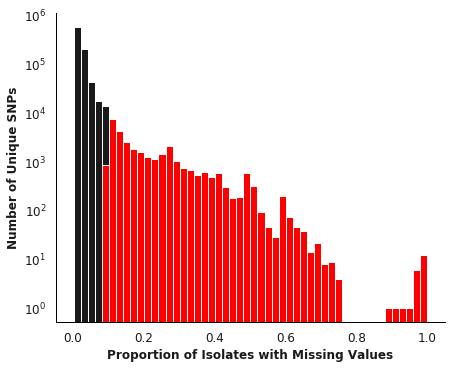

In [10]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist( missing_values_per_SNP / number_of_isolates , bins = 50 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=1.0)
plt.hist( missing_values_per_SNP[missing_values_per_SNP > max_number_values_missing_per_SNP] / number_of_isolates , bins = bins , color = 'red' , rwidth = 1.0 , edgecolor='white', linewidth=1.0)

#plt.title('Mean Coverage across sequenced isolates in rollingDB', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.xlabel('Proportion of Isolates with Missing Values', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.ylabel('Number of Unique SNPs', fontweight = 'bold' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')
ax.set_yscale("log", nonposy='clip')

fig = plt.gcf()
fig.set_size_inches(6.5, 5.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/genotypes_matrix_filtering/SNP_sites_dropped_per_missing_values.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [11]:
print 'Number of Isolates = ' + str( number_of_isolates )

Number of Isolates = 33873.0


Range and Average Number of Missing Values per SNP

In [12]:
np.min(missing_values_per_SNP)

62

In [13]:
np.mean(missing_values_per_SNP)

948.6810697174822

In [14]:
np.max(missing_values_per_SNP) 

33870

In [15]:
print 'SNP with most missing values is missing from ' + str( float(np.max(missing_values_per_SNP) ) / number_of_isolates * 100) + '% of isolates' 

SNP with most missing values is missing from 99.9911433885% of isolates


Drop SNPs that are flagged as 'missing values' in more than 10% of isolates in rollingDB

In [16]:
print sum( missing_values_per_SNP > max_number_values_missing_per_SNP )

31215


Percentage of SNPs with many missing values that we're going to drop from analysis

In [17]:
number_of_unique_SNPs = float(np.shape(genotypes_matrix)[0])
print 100.0 * ( sum( missing_values_per_SNP > max_number_values_missing_per_SNP ) / number_of_unique_SNPs )

3.589837361909428


#### FILTER out sites with missing calls in $> 10\%$ of isolates

Drop unique SNPs with a high abundance of missing values

In [18]:
np.shape( genotypes_matrix )

(869538, 33873)

Drop unique SNPs from the __GENOTYPE MATRIX__

In [19]:
len( missing_values_per_SNP <= max_number_values_missing_per_SNP )

869538

In [20]:
SNPs_to_keep_filter = missing_values_per_SNP <= max_number_values_missing_per_SNP

In [21]:
sum(SNPs_to_keep_filter)

838323

In [22]:
len(SNPs_to_keep_filter) - sum(SNPs_to_keep_filter) #number of sites dropped by this filter

31215

In [23]:
#store dataframe of SNPs that were dropped by this filtering step
SNPs_to_drop_filter = [not good_SNP for good_SNP in SNPs_to_keep_filter]
dropped_SNP_annotation_DF = SNP_annotation_DF[SNPs_to_drop_filter]
dropped_SNP_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/SNP_sites_dropped/3_dropped_SNPs_annotation_calls_missing_10perc_isolates.pkl')
np.shape(dropped_SNP_annotation_DF)

(31215, 3)

In [24]:
genotypes_matrix = genotypes_matrix[SNPs_to_keep_filter , :]

In [25]:
np.shape(genotypes_matrix) #Genotype Matrix

(838323, 33873)

Drop unique SNPs with a high abundance of missing values from the __SNP ANNOTATION FILE__

In [26]:
SNP_annotation_DF = SNP_annotation_DF[SNPs_to_keep_filter]

#re-index new filtered SNP annotation DF (so new index matches indexing of genotypes matrix rows)
SNP_annotation_DF.reset_index(drop = True , inplace = True)

In [27]:
SNP_annotation_DF.head()

,pos,ref,alt
0,44,C,[T]
1,48,C,[T]
2,64,G,[C]
3,67,G,"[A, T]"
4,69,C,[T]


In [28]:
np.shape(SNP_annotation_DF) #Annotation for Rows of Genotypes Matrix

(838323, 3)

Save __Genotypes Matrix__ in case kernel crashes when filtering

In [29]:
#save Genotypes Matrix
np.save('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_matrix' , genotypes_matrix , allow_pickle = True)

Save __SNP annotation file__ in case kernel crashes when filtering

In [30]:
SNP_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_SNP_annotation.pkl')

### (Filter 4) *FILTER* out SNPs that located in H37Rv Reference Positions with overlapping genes

In [12]:
#load Genotypes Matrix
## genotypes_matrix =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_matrix.npy')

#load SNP annotation file
## SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_SNP_annotation.pkl')

In [31]:
np.shape(genotypes_matrix)

(838323, 33873)

In [32]:
np.shape(SNP_annotation_DF)

(838323, 3)

#### Load dictionary that contains the mapping between each H37Rv Reference Position and H37Rv locus tag, from the file: */n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt*

In [33]:
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/dicts_for_SNP_annotation/H37Rv_coord_gene_mapping.pickle', 'rb') as handle:
    ReferencePosition_Gene_mapping = pickle.load(handle)

In [34]:
ReferencePosition_Gene_mapping[1] #one gene mapped to position

['Rv0001']

In [35]:
ReferencePosition_Gene_mapping[2282101] #two genes mapped to position (overlapping)

['Rv2035', 'Rv2036']

In [36]:
ReferencePosition_Gene_mapping[2281250] #no genes mapped to position (intergenic)

[]

#### FILTER out sites that map to 2 (or more) H37Rv locus tags

In [37]:
SNPs_to_keep_filter = np.array( [(len(ReferencePosition_Gene_mapping[ref_pos_i]) < 2) for ref_pos_i in SNP_annotation_DF.pos] )

In [38]:
sum(SNPs_to_keep_filter)

835979

In [39]:
len(SNPs_to_keep_filter) - sum(SNPs_to_keep_filter) #number of sites dropped by this filter

2344

In [40]:
#store dataframe of SNPs that were dropped by this filtering step
SNPs_to_drop_filter = [not good_SNP for good_SNP in SNPs_to_keep_filter]
dropped_SNP_annotation_DF = SNP_annotation_DF[SNPs_to_drop_filter]
dropped_SNP_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/SNP_sites_dropped/4_dropped_SNPs_annotation_overlapping_genes.pkl')
np.shape(dropped_SNP_annotation_DF)

(2344, 3)

In [41]:
#filter Genotypes Matrix
genotypes_matrix = genotypes_matrix[SNPs_to_keep_filter , :]

#filter SNP annotation file
SNP_annotation_DF = SNP_annotation_DF[SNPs_to_keep_filter]
SNP_annotation_DF.reset_index(drop = True , inplace = True) #re-index new filtered SNP annotation DF (so new index matches indexing of genotypes matrix rows)

In [42]:
np.shape(genotypes_matrix)

(835979, 33873)

In [43]:
SNP_annotation_DF.head()

,pos,ref,alt
0,44,C,[T]
1,48,C,[T]
2,64,G,[C]
3,67,G,"[A, T]"
4,69,C,[T]


In [44]:
np.shape(SNP_annotation_DF) #Annotation for Rows of Genotypes Matrix

(835979, 3)

Save __Genotypes Matrix__ in case kernel crashes when filtering

In [45]:
#save Genotypes Matrix
np.save('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_matrix' , genotypes_matrix , allow_pickle = True)

Save __SNP annotation file__ in case kernel crashes when filtering

In [46]:
SNP_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_SNP_annotation.pkl')

## [8.2] Drop low-quality isolates

### (Filter 5) *FILTER* out isolates that have missing base calls $> 10\%$ of SNP sites

In [12]:
#load Genotypes Matrix
## genotypes_matrix =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_matrix.npy')

#load SNP annotation file
## SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_SNP_annotation.pkl')

In [47]:
np.shape(genotypes_matrix)

(835979, 33873)

In [48]:
np.shape(SNP_annotation_DF)

(835979, 3)

#### Investigate the Number of Missing Calls for each Sequenced Isolate

Look for isolates with an abundance of missing values, drop isolates that have missing values > 10% of SNP calls

In [49]:
missing_values = genotypes_matrix == 9
missing_values_per_isolate = missing_values.sum(axis = 0) #will range from 0 - 835,979

In [50]:
#impose a threshold for maximum number of missing values per isolate (across all SNPs)
max_proportion_missing = 0.10
number_of_SNPs = float(np.shape(genotypes_matrix)[0])

max_number_values_missing_per_isolate = np.floor( max_proportion_missing * number_of_SNPs )

In [51]:
print max_number_values_missing_per_isolate #that we're going to allow

83597.0


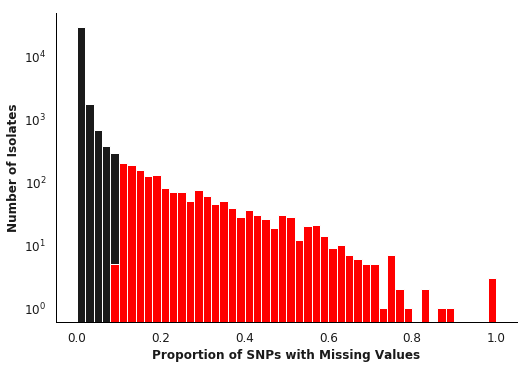

In [52]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist( missing_values_per_isolate / number_of_SNPs , bins = 50 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=1.0)
plt.hist( missing_values_per_isolate[missing_values_per_isolate > max_number_values_missing_per_isolate] / number_of_SNPs , bins = bins , color = 'red' , rwidth = 1.0 , edgecolor='white', linewidth=1.0)


#plt.title('Mean Coverage across sequenced isolates in rollingDB', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.xlabel('Proportion of SNPs with Missing Values', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.ylabel('Number of Isolates', fontweight = 'bold' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')
ax.set_yscale("log", nonposy='clip')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/genotypes_matrix_filtering/Samples_dropped_per_missing_values.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [53]:
print 'Number of unique SNPs = ' + str( number_of_SNPs )

Number of unique SNPs = 835979.0


Range and Average Number of Missing Values per unique SNP

In [54]:
np.min(missing_values_per_isolate)

170

In [55]:
np.mean(missing_values_per_isolate)

17680.30714728545

In [56]:
np.max(missing_values_per_isolate) 

835979

In [57]:
print 'Isolate with most missing values has ' + str( float(np.max(missing_values_per_isolate) ) / number_of_SNPs * 100) + '% missing values' 

Isolate with most missing values has 100.0% missing values


Drop isolates that are flagged as 'missing values' in more than 10% of isolates in rollingDB

In [58]:
print sum( missing_values_per_isolate > max_number_values_missing_per_isolate )

1663


Percentage of isolates with many missing values that we're going to drop from analysis

In [59]:
number_of_unique_isolates = float(np.shape(genotypes_matrix)[1])
print 100.0 * ( sum( missing_values_per_isolate > max_number_values_missing_per_isolate ) / number_of_unique_isolates )

4.90951495291235


#### FILTER out low-quality isolates with $> 10\%$ missing SNP calls

Drop unique isolates with a high abundance of missing values

In [60]:
np.shape( genotypes_matrix )

(835979, 33873)

Drop isolates from the __GENOTYPE MATRIX__

In [61]:
len( missing_values_per_isolate <= max_number_values_missing_per_isolate )

33873

In [62]:
isolates_to_keep_filter = missing_values_per_isolate <= max_number_values_missing_per_isolate

In [63]:
sum(isolates_to_keep_filter)

32210

In [64]:
len(isolates_to_keep_filter) - sum(isolates_to_keep_filter) #number of isolates dropped by this filter

1663

In [ ]:
genotypes_matrix = genotypes_matrix[: , isolates_to_keep_filter]

In [142]:
np.shape(genotypes_matrix) #Genotype Matrix

(835979, 32210)

Drop isolates with a high abundance of missing values from __ISOLATE ANNOTATION FILE__

In [66]:
isolate_annotation_series = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes/genotypes_isolate_annotation.pkl')

In [67]:
isolate_annotation_series.head()

0    SAMEA3558733
1    SAMN05575260
2    SAMN03648641
3    SAMN03647419
4    SAMEA3671418
dtype: object

In [68]:
np.shape(isolate_annotation_series) #Annotation for Columns of Genotypes Matrix

(33873,)

In [70]:
#store dataframe of isolates that were dropped by this filtering step
isolates_to_drop_filter = [not good_isolate for good_isolate in isolates_to_keep_filter]
dropped_isolate_annotation_series = isolate_annotation_series[isolates_to_drop_filter]
dropped_isolate_annotation_series.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/isolate_IDs_dropped/1_dropped_isolates_annotation_calls_missing_10perc_SNPs.pkl')
dropped_isolate_annotation_series.to_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/isolate_IDs_dropped/1_dropped_isolates_annotation_calls_missing_10perc_SNPs.csv')
np.shape(dropped_isolate_annotation_series)

(1663,)

In [71]:
isolate_annotation_series = isolate_annotation_series[isolates_to_keep_filter]

#re-index new filtered isolate annotation series (so new index matches indexing of genotypes matrix columns)
isolate_annotation_series.reset_index(drop = True , inplace = True)

In [72]:
isolate_annotation_series.head()

0    SAMEA3558733
1    SAMN03648641
2    SAMN03647419
3    SAMEA3671418
4    SAMN07659096
dtype: object

In [73]:
np.shape(isolate_annotation_series) #Annotation for Columns of Genotypes Matrix

(32210,)

#### Save annotation files and genotypes matrix

In [149]:
#save isolate annotation file (columns of Genotype Matrix)
isolate_annotation_series.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_isolate_annotation.pkl')

#save SNP annotation file (rows of Genotype Matrix)
SNP_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_SNP_annotation.pkl')

#save Genotypes Matrix
np.save('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_matrix' , genotypes_matrix , allow_pickle = True)

####################################################################################################################################################################################

## [9] Annotate SNPs w/ H37Rv Locus Info

####################################################################################################################################################################################

#### Retrieve information for H37Rv Reference Genome

In [150]:
####################################################################################################################################################################################
#load reference genome and reference annotation
reference_genome = '/home/rv76/Farhat_Lab/Reference_Seqs/H37Rv/h37rv.fasta'
for reference_genome in SeqIO.parse(reference_genome, "fasta"):
    reference_genome.seq.alphabet = IUPAC.unambiguous_dna

reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

####### Make a dictionary of all H37Rv reference positions and corresponding genes #######
ReferencePosition_Gene_mapping = {} #keys: H37Rv Reference Positions , values: gene_ids (may be multiple genes for some Reference Positions)

#store a list corresponding to every Reference Position (to store all genes that map to the Reference Position)
for H37Rv_RefPos in range(0 , len(reference_genome.seq) + 1):
    ReferencePosition_Gene_mapping[H37Rv_RefPos] = []

for gene_id_index in range(0 , len(reference_genome_annotation.index)):

    gene_id_info = reference_genome_annotation.ix[gene_id_index , :]
    gene_id = gene_id_info.name

    chrom_start = gene_id_info.chromStart
    chrom_end = gene_id_info.chromEnd

    #find the position of the first base relative to H37Rv in 5' -> 3'
    H37Rv_start = min(chrom_start , chrom_end)
    H37Rv_end = max(chrom_start , chrom_end)

    #store all corresponding H37Rv Reference Positions to gene_id in dictionary
    for H37Rv_RefPos in range(H37Rv_start+1 , H37Rv_end+1):

        ReferencePosition_Gene_mapping[H37Rv_RefPos].append(gene_id) #append gene_id to list already in dict
####################################################################################################################################################################################

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


#### Annotate SNPs

To annotate SNPs, we get gene_ids that the SNPs 'land in' and the gene-relative coordinate.

In [151]:
#load SNP annotation file (rows of Genotype Matrix)
SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_SNP_annotation.pkl')

SNP_annotation_DF.head()

,pos,ref,alt
0,44,C,[T]
1,48,C,[T]
2,64,G,[C]
3,67,G,"[A, T]"
4,69,C,[T]


In [152]:
np.shape(SNP_annotation_DF)

(835979, 3)

#### Gene Categories

In [153]:
#get Gene Categories
gene_categories = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv').set_index('name')

#create dictionary, keys: H37Rv locus, values: gene category
gene_categories_map = dict( zip( list(gene_categories.gene_id) , list(gene_categories.Gene_Category) ) ) 

#### Gene Names

Parse through Mycobrowser (tuberculist) to collect gene names

In [154]:
mycobrowser_table = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/Mycobrowser_Release3/Mycobacterium_tuberculosis_H37Rv_txt_v3.txt' , sep = '\t')

#retreive columns for locus tag & gene name
mycobrowser_table = mycobrowser_table.loc[: , ['Locus' , 'Name']]

#create dictionary, keys: H37Rv loucs, values: gene category
gene_names_map = dict( zip( list(mycobrowser_table.Locus) , list(mycobrowser_table.Name) ) ) 

#### Iterate through each SNP to annotate

Some SNPs are present in more than 1 gene, have to account for this

In [162]:
#create dictionaries for each columsn of information
locus_tag_dict = {} #H37Rv id
genomic_coord_dict = {} #coordinate on gene, 5' -> 3'
gene_categ_dict = {} #gene Category
gene_name_dict = {} #gene Name

for SNP_index in SNP_annotation_DF.index:

    #reference position, ref allele and alt allele for SNP
    SNP_info = SNP_annotation_DF.loc[SNP_index , :]

    #find the gene that SNP occurs on
    ref_seq_position = SNP_info.pos

    #check list corresponding to H37Rv coordinate to see if there are any genes associated with RefPosition
    if len(ReferencePosition_Gene_mapping[ref_seq_position]) == 1:
        
        #get gene that ReferencePosition is mapped to (i.e. SNP filtering ensures that SNP corresponds to only 1 gene)
        gene_intergenic_id = ReferencePosition_Gene_mapping[ref_seq_position][0]

        #find genomic coordinate of SNP relative to gene (subtract 1 since reference seq starts counting at 1)
        gene_relative_coord = (ref_seq_position - 1) - min( reference_genome_annotation.loc[gene_intergenic_id , 'chromStart'] , reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd'] )

        #store all information for SNP in relevant dictionaries
        locus_tag_dict[SNP_index] = gene_intergenic_id
        genomic_coord_dict[SNP_index] = gene_relative_coord

        #use gene id to get category and names from mappings
        if gene_intergenic_id in gene_categories_map.keys():
            gene_categ_dict[SNP_index] = gene_categories_map[gene_intergenic_id]
        else:
            gene_categ_dict[SNP_index] = 'None'

        if gene_intergenic_id in gene_names_map.keys():
            gene_name_dict[SNP_index] = gene_names_map[gene_intergenic_id] 
        else:
            gene_name_dict[SNP_index] = 'None'
            
    #H37Rv RefSeq position was not found in dictionary so Reference position must be intergenic    
    elif len(ReferencePosition_Gene_mapping[ref_seq_position]) == 0:

        #store all information for SNP in relevant dictionaries
        locus_tag_dict[SNP_index] = 'intergenic'
        genomic_coord_dict[SNP_index] = np.nan
        gene_categ_dict[SNP_index] = 'None'
        gene_name_dict[SNP_index] = 'None'

    #keep track of progress of loop
    num_SNPs = float( np.shape(SNP_annotation_DF)[0] )
    if SNP_index % np.ceil(0.20 * num_SNPs) == 0:
        print float(SNP_index) / num_SNPs

0.0
0.20000023924
0.400000478481
0.600000717721
0.800000956962


#### Update SNP annotation DF

In [163]:
#append columns for info from annotation
SNP_annotation_DF['gene_id'] = pd.Series(locus_tag_dict)
SNP_annotation_DF['gene_pos'] = pd.Series(genomic_coord_dict)
SNP_annotation_DF['gene_category'] = pd.Series(gene_categ_dict)
SNP_annotation_DF['gene_name'] = pd.Series(gene_name_dict)

In [164]:
np.shape( SNP_annotation_DF )

(835979, 7)

In [165]:
SNP_annotation_DF.head()

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
0,44,C,[T],Rv0001,43.0,Essential,dnaA
1,48,C,[T],Rv0001,47.0,Essential,dnaA
2,64,G,[C],Rv0001,63.0,Essential,dnaA
3,67,G,"[A, T]",Rv0001,66.0,Essential,dnaA
4,69,C,[T],Rv0001,68.0,Essential,dnaA


In [166]:
SNP_annotation_DF.tail()

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
835974,4411494,C,[G],intergenic,NaN,None,None
835975,4411499,A,[G],intergenic,NaN,None,None
835976,4411500,C,[T],intergenic,NaN,None,None
835977,4411501,C,[T],intergenic,NaN,None,None
835978,4411502,C,[G],intergenic,NaN,None,None


In [167]:
#update SNP annotation file (rows of Genotype Matrix) with extra SNP information
SNP_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_SNP_annotation_with_gene_info.pkl')

How to investigate SNPs that appeared within a particular gene

In [168]:
SNP_annotation_DF[['Rv0667' in gene_list for gene_list in SNP_annotation_DF.gene_id]].head()

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
160931,759814,A,[G],Rv0667,7.0,Antibiotic Resistance,rpoB
160932,759818,C,[T],Rv0667,11.0,Antibiotic Resistance,rpoB
160933,759836,C,[T],Rv0667,29.0,Antibiotic Resistance,rpoB
160934,759841,G,[C],Rv0667,34.0,Antibiotic Resistance,rpoB
160935,759851,G,[T],Rv0667,44.0,Antibiotic Resistance,rpoB
